# Libraries

In [1]:
# General-purpose imports
import pickle
import numpy as np
import pandas as pd
from os.path import exists
from collections import Counter
import string

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from nltk.corpus import stopwords

# Machine Learning model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
# Model evaluation and selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

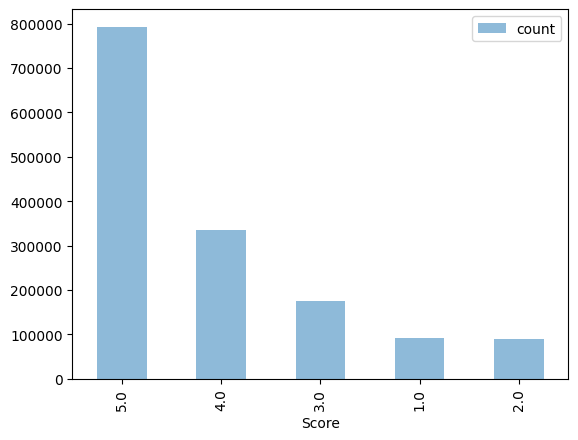


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
train_df= pd.read_csv("./data/train.csv")
trainingSet = train_df
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [3]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/simonwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Adding Features

In [35]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob  # For sentiment analysis
from scipy import stats 
import pandas as pd
import numpy as np

NEGATION_WORDS = ["not", "never", "none", "cannot", "can't", "won't", "didn't"]
POSITIVE_WORDS = ["good", "great", "excellent", "love", "amazing", "wonderful", "best", "fantastic", "perfect"]

def detect_negation(text):
    """Return 1 if any negation word is detected, otherwise 0."""
    text = text.lower()
    return 1 if any(neg_word in text for neg_word in negation_words) else 0

def detect_positive(text):
    """Return 1 if any positive word is detected, otherwise 0."""
    text = text.lower()
    return 1 if any(pos_word in text for pos_word in positive_words) else 0

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()
def clean_text(text):
    """Cleans text by lowercasing and removing non-alphanumeric characters."""
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

def extract_text_features(text):
    """Extracts basic features from text such as character count, word count, etc."""
    char_count = len(text)
    word_count = len(text.split())
    unique_word_count = len(set(text.split()))
    return pd.Series([char_count, word_count, unique_word_count], index=['char_count', 'word_count', 'unique_word_count'])

def get_sentiment_scores(text):
    """Uses VADER to extract sentiment scores."""
    scores = sia.polarity_scores(text)
    return pd.Series([scores['compound'], scores['pos'], scores['neg'], scores['neu']],
                     index=['vader_compound', 'vader_pos', 'vader_neg', 'vader_neu'])

def preprocess_text(text):
    """Convert text to lowercase, remove punctuation, and filter out stopwords."""
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(words)
# Apply feature engineering to the dataset

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simonwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
# Define functions for skewness and kurtosis
def calculate_skewness(x):
    return stats.skew(x) if len(x) > 2 else 0

def calculate_kurtosis(x):
    return stats.kurtosis(x) if len(x) > 2 else 0

def feature_engineering(df):
    """Enhanced feature engineering with advanced text and statistical analysis."""
    # Make a copy and clean text
    df = df.copy()
    df['clean_text'] = df['Text'].fillna('').apply(clean_text)
    df['clean_summary'] = df['Summary'].fillna('').apply(clean_text)
    
    # 1. Advanced Text Features
    text_features = df['clean_text'].apply(extract_text_features)
    summary_features = df['clean_summary'].apply(extract_text_features)
    
    # 2. Enhanced Sentiment Analysis
    text_sentiment = df['clean_text'].apply(get_sentiment_scores)
    summary_sentiment = df['clean_summary'].apply(get_sentiment_scores)
    
    # 3. Basic Flags
    df['negation_flag'] = df['clean_text'].apply(lambda x: sum(1 for word in x.split() if word in NEGATION_WORDS)) * 6
    df['positive_flag'] = df['clean_text'].apply(lambda x: sum(1 for word in x.split() if word in POSITIVE_WORDS)) * 1
    df['net_sentiment'] = df['positive_flag'] - df['negation_flag']
    
    # 4. Enhanced Helpfulness Features
    df['helpfulness_ratio'] = np.where(
        df['HelpfulnessDenominator'] > 0,
        df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
        0
    )
    
    # Add smoothing to helpfulness ratio
    alpha = 1
    df['smoothed_helpfulness'] = (df['HelpfulnessNumerator'] + alpha) / (df['HelpfulnessDenominator'] + 2 * alpha)
    
    # 5. Advanced User-level Features
    user_features = df.groupby('UserId').agg({
        'helpfulness_ratio': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis],
        'HelpfulnessNumerator': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis],
        'HelpfulnessDenominator': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis]
    })
    user_features.columns = ['_'.join(col).strip() for col in user_features.columns]
    user_features = user_features.reset_index()
    
    # Merge user-level features back into the main dataframe
    df = df.merge(user_features, on='UserId', how='left')
    
    # 6. Advanced Product-level Features
    product_features = df.groupby('ProductId').agg({
        'helpfulness_ratio': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis],
        'HelpfulnessNumerator': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis],
        'HelpfulnessDenominator': ['mean', 'median', 'std', calculate_skewness, calculate_kurtosis]
    })
    product_features.columns = ['_'.join(col).strip() for col in product_features.columns]
    product_features = product_features.reset_index()
    
    # Merge product-level features back into the main dataframe
    df = df.merge(product_features, on='ProductId', how='left')
    
    # 7. Time-based Features
    df['timestamp'] = pd.to_datetime(df['Time'], unit='s')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # 8. Combine all features
    feature_sets = [
        text_features.add_prefix('text_'),
        summary_features.add_prefix('summary_'),
        text_sentiment.add_prefix('text_'),
        summary_sentiment.add_prefix('summary_'),
        df[[
            'negation_flag', 'positive_flag', 'net_sentiment',
            'helpfulness_ratio', 'smoothed_helpfulness', 'hour', 
            'day_of_week', 'is_weekend'
        ]]
    ]
    
    # Combine all features
    combined_features = pd.concat(feature_sets, axis=1)
    
    # 9. Create interaction features
    combined_features['sentiment_helpfulness'] = combined_features['text_vader_compound'] * combined_features['helpfulness_ratio']
    combined_features['length_helpfulness'] = combined_features['text_char_count'] * combined_features['helpfulness_ratio']
    
    # 10. Fill missing values
    combined_features = combined_features.fillna(0)
    
    return combined_features

# Sample + Split into training and testing set



In [92]:
# Step 1: Randomly sample 100,000 rows from train_df
train_df = pd.read_csv("./data/train.csv")
trainingSet = train_df.sample(n=100000, random_state=42).reset_index(drop=True)

# Step 2: Remove rows with NaN values in the 'Score' column
trainingSet = trainingSet.dropna(subset=['Score']).reset_index(drop=True)
print("TrainingSet shape after dropping NaN scores:", trainingSet.shape)

TrainingSet shape after dropping NaN scores: (87424, 9)


In [93]:
from scipy import stats 
# Step 3: Apply feature engineering to generate X_train
X_train = feature_engineering(trainingSet)
print("Feature engineering on training set completed.")

# Step 4: Define the target variable y_train
y_train = trainingSet['Score'].reset_index(drop=True)
print("Target variable `y_train` extracted.")

/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:6: RuntimeWarning: Precision l

Feature engineering on training set completed.
Target variable `y_train` extracted.


In [94]:

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

# Split data into training and validation sets
X_train_data, X_val, y_train_data, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame(X_train_data)
train_df['label'] = y_train_data

# Separate each class for targeted sampling
class_1 = train_df[train_df['label'] == 1]
class_2 = train_df[train_df['label'] == 2]
class_3 = train_df[train_df['label'] == 3]
class_4 = train_df[train_df['label'] == 4]
class_5 = train_df[train_df['label'] == 5]
count_class_4 = class_4.shape[0]
# Calculate target size for classes 1, 2, and 3 (1.8 times the size of class 4)
target_count = int(0.3 * class_4.shape[0])
target_count_5 = int(3 * count_class_4)

# Undersample class 5 to match the target count
class_5_undersampled = resample(class_5, replace=True, n_samples=int(12* count_class_4), random_state=42)
class_4_undersampled = resample(class_4, replace=True, n_samples=int(1*  count_class_4), random_state=42)

# Oversample classes 1, 2, and 3 to match the target count
class_1_oversampled = resample(class_1, replace=True, n_samples=int(1* count_class_4), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=int(1.3* count_class_4), random_state=42)
class_3_oversampled = resample(class_3, replace=True, n_samples=int(1* count_class_4), random_state=42)

# Combine all classes back together
train_balanced_df = pd.concat([class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_undersampled, class_5_undersampled])

# Separate features and target
X_train_balanced = train_balanced_df.drop(columns='label').values
y_train_balanced = train_balanced_df['label'].values

X_train_balanced = X_train_data
y_train_balanced = y_train_data
# Confirm the new class distribution
print("Class distribution after oversampling classes 1, 2, and 3:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution after oversampling classes 1, 2, and 3:
Score
5.0    37411
4.0    15841
3.0     8182
1.0     4347
2.0     4158
Name: count, dtype: int64


In [95]:
# Adjust labels to be 0-based
y_train_balanced = y_train_balanced -1
y_train_balanced = y_train_balanced.astype(int)  # Ensure integer type for compatibility
y_val = y_val-1
y_val = y_val.astype(int)


Unique values in y_train_balanced after adjustment: [0 1 2 3 4]
Unique values in y_val after adjustment: [0 1 2 3 4]
[0]	train-mlogloss:1.54464	validation-mlogloss:1.54505
[20]	train-mlogloss:1.13960	validation-mlogloss:1.14387
[40]	train-mlogloss:1.07340	validation-mlogloss:1.08040
[60]	train-mlogloss:1.05007	validation-mlogloss:1.06013
[80]	train-mlogloss:1.03799	validation-mlogloss:1.05062
[100]	train-mlogloss:1.02944	validation-mlogloss:1.04418
[120]	train-mlogloss:1.02287	validation-mlogloss:1.03967
[140]	train-mlogloss:1.01761	validation-mlogloss:1.03654
[160]	train-mlogloss:1.01358	validation-mlogloss:1.03440
[180]	train-mlogloss:1.00991	validation-mlogloss:1.03262
[199]	train-mlogloss:1.00667	validation-mlogloss:1.03126

Validation Accuracy: 0.5702602230483271

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.52      0.49      1087
           1       0.27      0.07      0.11      1039
           2       0.33      0.10

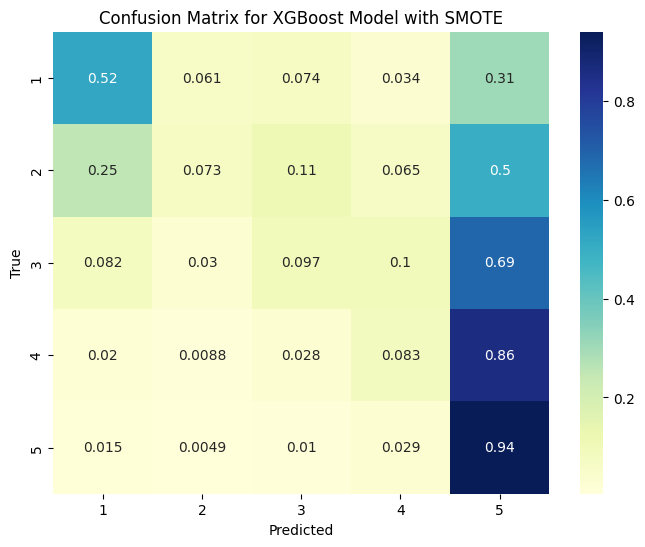

In [99]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("Unique values in y_train_balanced after adjustment:", np.unique(y_train_balanced))
print("Unique values in y_val after adjustment:", np.unique(y_val))

# Ensure num_class is exactly 5 if labels are in [0, 4]
params = {
    'objective': 'multi:softmax',
    'num_class': 5,  # Set to 5 if labels are [0, 4]
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 1.0,
    'colsample_bytree': 1,
    'eval_metric': 'mlogloss',
    'seed': 42
}

# Scale features
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
# Adjust labels to be 0-based

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_balanced_scaled, label=y_train_balanced)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

# Train the XGBoost model with early stopping
num_rounds = 200
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=20
)

# Make predictions on the validation set
y_val_pred = model.predict(dval)
y_val_pred = y_val_pred.astype(int)

# Evaluate model performance
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title('Confusion Matrix for XGBoost Model with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [97]:
train_df= pd.read_csv("./data/train.csv")


# Step 1: Merge test and train data on 'Id' to create `merged_data`
merged_data = pd.merge(testingSet, train_df, on='Id', how='left')
print("Merged data shape:", merged_data.shape)

# Step 2: Apply feature engineering to generate `X_test`
X_test = feature_engineering(merged_data)

# Step 3: Scale the test data features using the same scaler fitted on training data
X_test_scaled = scaler.transform(X_test)



Merged data shape: (212192, 10)


/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(x) if len(x) > 2 else 0
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_65797/535627848.py:6: RuntimeWarning: Precision l

In [98]:
dtest = xgb.DMatrix(X_test_scaled)

# Make predictions on the test set using DMatrix
y_test_pred = model.predict(dtest).astype(int)+1
print("Predictions for `X_test`:", y_test_pred)

# Generate the final submission file
submission = pd.DataFrame({
    "Id": testingSet['Id'],
    "Score": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")
print("Submission shape:", submission.shape)



Predictions for `X_test`: [5 5 5 ... 5 5 5]
Submission file created: submission.csv
Submission shape: (212192, 2)
